For this tutorial, we will examine how the mean squared out-of-sample prediction error of the OLS estimator changes as the sample size $n$ and dimension $d$ grow. This will also be a helpful introduction to Monte Carlo simulation. 

In the simulation we draw data from the following model:
\begin{align*}
\begin{pmatrix}X_{i}\\
U_{i}
\end{pmatrix} & \sim N(0,I)\\
Y_{i} & =\beta_{0}'X_{i}+U_{i}
\end{align*}

The OLS estimator in this case has the formula below:
$$
\hat{\beta}=(\frac{1}{n}\sum_{i=1}^{n}X_{i}X_{i}')^{-1}\frac{1}{n}\sum_{i=1}^{n}X_{i}Y_{i}
$$

We wish to estimate the mean squared error of the corresponding prediction
model for various combinations of sample size and dimension of $X_{i}$. Given the model, we can re-write this as:
$$
\hat{\beta}=\beta_{0}+(\frac{1}{n}\sum_{i=1}^{n}X_{i}X_{i}')^{-1}\frac{1}{n}\sum_{i=1}^{n}X_{i}U_{i}
$$

A very useful practical point that allows us to speed up our simulations, is that the above only depends on the following matrix:
$$
\frac{1}{n}\sum_{i=1}^{n}(X_{i}',U_{i})'(X_{i}',U_{i})
$$
Rather than draw $n$ separate observations for each simulation (which could make things very slow for large $n$), we will just draw the above directly from its distribution. Details of this distribution are given at the end of this notebook).

We can use the same trick when calculating the mean squared error
on the test sample. Note that the mean squared error can be expanded
as follows:

\begin{align*}
 & \frac{1}{n}\sum_{i=1}^{n}(Y_{i}-X_{i}'\hat{\beta})^{2}\\
= & \frac{1}{n}\sum_{i=1}^{n}Y_{i}^{2}-2\frac{1}{n}\sum_{i=1}^{n}Y_{i}X_{i}'\hat{\beta}+\hat{\beta}'\frac{1}{n}\sum_{i=1}^{n}X_{i}X_{i}'\hat{\beta}
\end{align*}

Subtracting off the mean squared error from the prediction $X_{i}'\beta_{0}$
we get:

\begin{align*}
 & \frac{1}{n}\sum_{i=1}^{n}(Y_{i}-X_{i}'\hat{\beta})^{2}-\frac{1}{n}\sum_{i=1}^{n}(Y_{i}-X_{i}'\beta_{0})^{2}\\
= & -2\frac{1}{n}\sum_{i=1}^{n}Y_{i}X_{i}'(\hat{\beta}-\beta_{0})+\hat{\beta}'\frac{1}{n}\sum_{i=1}^{n}X_{i}X_{i}'\hat{\beta}-\beta_{0}'\frac{1}{n}\sum_{i=1}^{n}X_{i}X_{i}'\beta_{0}
\end{align*}

Where $\frac{1}{n}\sum_{i=1}^{n}Y_{i}X_{i}'=\beta_{0}'\frac{1}{n}\sum_{i=1}^{n}X_{i}X_{i}'+\frac{1}{n}\sum_{i=1}^{n}U_{i}X_{i}'$
which can again be written in terms of blocks of the matrix $\frac{1}{n}\sum_{i=1}^{n}(X_{i}',U_{i})'(X_{i}',U_{i})$.

In [124]:
#First we need to import  the relevant libraries.

import numpy as np  # Numpy (handles all of our linear algebra and stats needs)
import matplotlib.pyplot as plt  #For nice plots
from scipy.stats import wishart  #We will draw random Wishart matrices for the simulation (see

In [126]:
# Now we will set the parameters of our simulation. Comment/uncomment and play around with these.
num_simulations = 1000  # Number of simulations
test_sample_size = 10000 #Test sample sizes.

#We will examine how the mean-squared out-of-sample prediction error changes with the sample size n and sumber of features d.
sample_sizes = [1000, 2000, 5000, 10000] #We simulate using a sequence of smaple sizes `n'
num_regressors = [30, 30, 30, 30]  # First we keep the number of regressors fixed #And a sequence of numbers of features `d'


In [128]:
#Now we run the simulation.

# Initialize list to store results
mse_values = []

# Monte Carlo simulation
for k in range(len(num_regressors)):
    p = num_regressors[k]  # Number of regressors
    n = sample_sizes[k]    # Number of observations
    mse_sim = []           # Store MSE for each simulation
    
    print(f"Processing p = {p}")  # To track progress
    
    for sim in range(num_simulations):
        # Generate the sample covariance matrices using the Wishart distribution
        S_train = wishart.rvs(df=n, scale=np.diag([1] * (p + 1)) / n)
        S_test = wishart.rvs(df=test_sample_size, scale=np.diag([1] * (p + 1)) / test_sample_size)

        # Extract submatrices from the Wishart matrices
        XX_train = S_train[:p, :p]  # X'X/n on the training sample
        XU_train = S_train[:p, p:p+1]  # X'U/n on the training sample
        XX_test = S_test[:p, :p]  # X'X/n on the test sample
        XU_test = S_test[:p, p:p+1]  # X'U/n on the test sample

        # Generate the true regression coefficients
        beta_true = np.random.normal(size=(p, 1))  # Column vector

        # Calculate X'Y/n for training and test samples
        XY_train = np.dot(XX_train, beta_true) + XU_train
        XY_test = np.dot(XX_test, beta_true) + XU_test

        # Compute the OLS estimates for beta
        beta_hat = np.linalg.solve(XX_train, XY_train)

        # Calculate the MSE on the test sample relative to the true model
        mse = (
            -2 * np.dot(XY_test.T, (beta_hat - beta_true))
            + np.dot(beta_hat.T, np.dot(XX_test, beta_hat))
            - np.dot(beta_true.T, np.dot(XX_test, beta_true))
        )
        
        mse_sim.append(mse.item())  # Extract scalar value

    # Store the mean MSE for this configuration
    mse_values.append(np.mean(mse_sim))


Processing p = 30
Processing p = 30
Processing p = 30
Processing p = 30


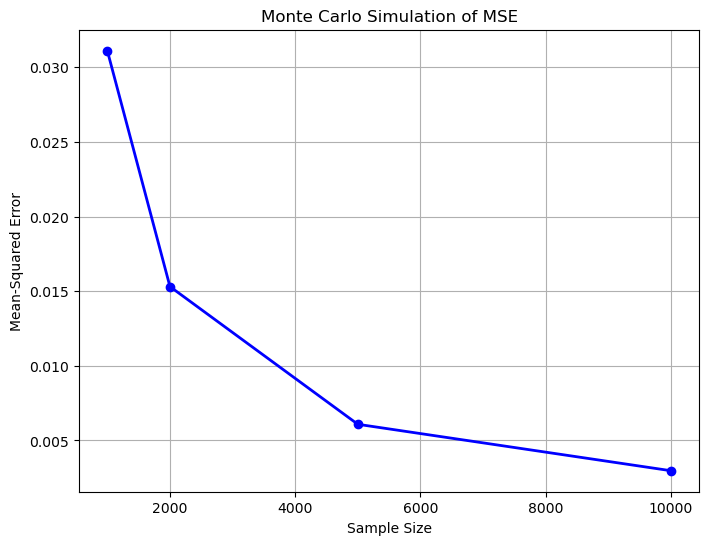

In [130]:
# Finally, we plot the results
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, mse_values, marker="o", color="blue", linewidth=2)
plt.xlabel("Sample Size")
plt.ylabel("Mean-Squared Error")
plt.title("Monte Carlo Simulation of MSE")
plt.grid(True)
plt.show()


Finally a little detail on how we draw the matrix $\frac{1}{n}\sum_{i=1}^{n}(X_{i}',U_{i})'(X_{i}',U_{i})$ for the curious. A useful fact is that if an iid random vector $Z_{i}$ has a zero
mean normal distribution with variance-covariance matrix $\Sigma$,
then $\frac{1}{n}\sum_{i=1}^{n}Z_{i}Z_{i}'$ has what is known as
a Wishart distribution with $n$ degrees of freedom and `scale matrix'
$\Sigma/n$. We write, $\frac{1}{n}\sum_{i=1}^{n}Z_{i}Z_{i}'\sim W_{p}(\Sigma/n,n)$,
where $p$ is the dimension of $Z_{i}$. Thus to reduce the computational
intensity of the simulation, we draw $\frac{1}{n}\sum_{i=1}^{n}(X_{i}',U_{i})'(X_{i}',U_{i})$
from $W_{p}(I,n)$.